In [1]:
from datasets import load_dataset

train = '/kaggle/input/nlp-getting-started/train.csv'
test = '/kaggle/input/nlp-getting-started/test.csv'
sample = '/kaggle/input/nlp-getting-started/sample_submission.csv'

dataset = load_dataset("csv", data_files=train)

Generating train split: 0 examples [00:00, ? examples/s]

In [2]:
train = dataset['train']
train[1]

{'id': 4,
 'keyword': None,
 'location': None,
 'text': 'Forest fire near La Ronge Sask. Canada',
 'target': 1}

In [3]:
import pandas as pd

train.set_format(type="pandas")
df = dataset["train"][:]
df.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,5,None,None,All residents asked to 'shelter in place' are ...,1
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1


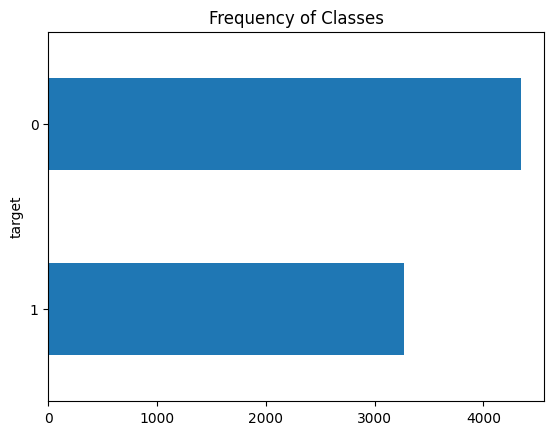

In [4]:
import matplotlib.pyplot as plt

df["target"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

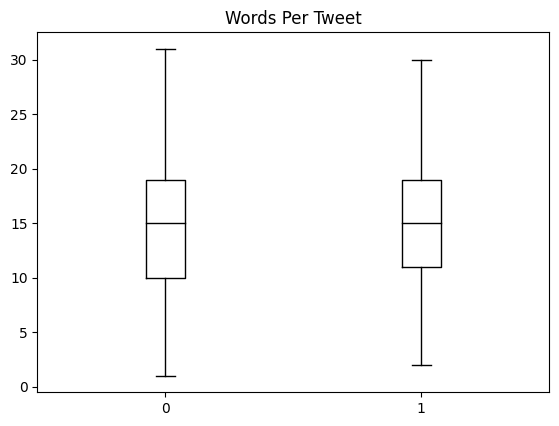

In [5]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="target", grid=False,
           showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [6]:
## Retornar formato original
dataset.reset_format()

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 7613
    })
})

In [8]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(dataset["train"][:2]))

{'input_ids': [[101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102], [101, 3224, 2543, 2379, 2474, 6902, 3351, 21871, 2243, 1012, 2710, 102, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]}


In [10]:
enc = dataset.map(tokenize, batched=True, batch_size=None)
print(enc["train"].column_names)

Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

['id', 'keyword', 'location', 'text', 'target', 'input_ids', 'attention_mask']


In [11]:
enc

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', 'input_ids', 'attention_mask'],
        num_rows: 7613
    })
})

In [12]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [13]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [14]:
enc.set_format("torch", columns=["input_ids", "attention_mask", "target"])

In [15]:
enc_h = enc.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

In [16]:
enc_h['train'][0]

{'target': tensor(1),
 'input_ids': tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
          2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
enc_h["train"].column_names

['id',
 'keyword',
 'location',
 'text',
 'target',
 'input_ids',
 'attention_mask',
 'hidden_state']

In [18]:
import numpy as np

data = enc_h['train']
X, y = data['hidden_state'], data['target']

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [20]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [21]:
lr_clf.score(X_test, y_test)

0.8201352964584162

In [22]:
test = load_dataset("csv", data_files=test)
test

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text'],
        num_rows: 3263
    })
})

In [23]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(test["train"][:2]))

{'input_ids': [[101, 2074, 3047, 1037, 6659, 2482, 5823, 102, 0, 0, 0, 0, 0, 0], [101, 2657, 2055, 1001, 8372, 2003, 2367, 3655, 1010, 2994, 3647, 3071, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [24]:
test_enc = test.map(tokenize, batched=True, batch_size=None)
print(test_enc["train"].column_names)

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

['id', 'keyword', 'location', 'text', 'input_ids', 'attention_mask']


In [25]:
test_enc.set_format("torch", 
                            columns=["input_ids", "attention_mask"])

In [26]:
test_h = test_enc.map(extract_hidden_states, batched=True)
test_h['train'][0]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

{'input_ids': tensor([ 101, 2074, 3047, 1037, 6659, 2482, 5823,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]),
 'hidden_state': tensor([ 2.2486e-02, -5.9863e-02,  2.6799e-02, -2.9579e-02,  9.7490e-03,
         -1.9274e-01,  3.7549e-01,  5.9481e-01, -1.8286e-01, -1.4163e-01,
          1.2316e-01, -7.2473e-02, -1.0537e-0

In [27]:
test_h["train"].column_names

['id',
 'keyword',
 'location',
 'text',
 'input_ids',
 'attention_mask',
 'hidden_state']

In [28]:
test_h['train'][:]

{'input_ids': tensor([[  101,  2074,  3047,  ...,     0,     0,     0],
         [  101,  2657,  2055,  ...,     0,     0,     0],
         [  101,  2045,  2003,  ...,     0,     0,     0],
         ...,
         [  101,  2665,  2240,  ...,     0,     0,     0],
         [  101, 12669,  3314,  ...,     0,     0,     0],
         [  101,  1001,  2103,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'hidden_state': tensor([[ 0.0225, -0.0599,  0.0268,  ..., -0.2165,  0.3224,  0.2605],
         [ 0.0569, -0.3009,  0.1697,  ..., -0.2925,  0.3900,  0.1499],
         [ 0.0303, -0.0414, -0.0913,  ..., -0.0297,  0.4202,  0.2444],
         ...,
         [-0.0989, -0.3587, -0.3666,  ..., -0.0581,  0.3347,  0.3675],
         [-0.4916, -0.2319, -0.1179,  ..., -0.2530,  0.3460

In [29]:
sample = load_dataset("csv", data_files='/kaggle/input/nlp-getting-started/sample_submission.csv')
sample.set_format(type="pandas")
df = sample["train"][:]

final = test_h['train']['hidden_state']
df['target'] = lr_clf.predict(final)
df.to_csv('csv.csv', index=False)

Generating train split: 0 examples [00:00, ? examples/s]